# Welcome to the icet Monte-Carlo tutorial part 2

In this tutorial we will showcase how analyzing Monte Carlo simulations can be done in efficient way.

In `reference_data/canonical_runs/` and `reference_data/sgc_runs/` you will find the resulting datacontainers from MC-simulations carried out for the same Ising model used in the previous notebook and a system size of 12x12x12.

These have been sampled for about 5000 MC-cycles, where one MC-cycle corresponds to $N_{atoms}$ trial steps.

In [1]:
# Setup plotting, seaborn is just used to make figures look a bit nicer
%matplotlib inline

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print("Don't worry")

## Canonical simulations
We'll start with collecting the results from the canonical MC-simulations and store the thermodynamic properties in a pandas dataframe.

The heat capacity is computed using

\begin{equation}
C_V(T) = \frac{\left < E(T)^2\right > - \left < E(T)\right >^2}{k_BT^2}
\end{equation}



In [2]:
import glob
import pandas as pd
import numpy as np
from ase.units import kB
from mchammer import DataContainer

pd.set_option('display.max_rows', 10, 'display.max_columns', 5)


# collect data
size = 12
eq_steps = 5000

dc_fnames = glob.glob('reference_data/canonical_runs/dc_size{}*.dc'.format(size))
records = []
for fname in dc_fnames:

    # ensemble parameters
    dc = DataContainer.read(fname)
    n_atoms = dc.ensemble_parameters['n_atoms']
    n_Si = dc.ensemble_parameters['n_atoms_Si']
    T = dc.ensemble_parameters['temperature']
    c_Si = n_Si / n_atoms

    # thermodynamic data
    energies = dc.get('potential', start=eq_steps)
    sros = dc.get('sro_Ge_1', start=eq_steps)
    acceptance_ratio = dc.get('acceptance_ratio', start=eq_steps)

    heat_capacity = np.var(energies) / (kB*T**2) / n_atoms
    energies /= n_atoms

    row = dict(temperature=T, c_Si=c_Si, energy=energies.mean(), energy_std=energies.std(),
               sro=sros.mean(), sro_std=sros.std(), heat_capacity=heat_capacity,
               acceptance_ratio=acceptance_ratio.mean())
    records.append(row)

df_all = pd.DataFrame(records)
print(df_all)

    temperature      c_Si  ...  heat_capacity  acceptance_ratio
0          2000  0.299769  ...       0.000013          0.505619
1          2000  0.500000  ...       0.000019          0.463631
2          1600  0.500000  ...       0.000064          0.288901
3          1300  0.099537  ...       0.000015          0.452523
4          1750  0.299769  ...       0.000025          0.422126
..          ...       ...  ...            ...               ...
79         1900  0.500000  ...       0.000024          0.431129
80         1850  0.299769  ...       0.000018          0.459273
81          700  0.299769  ...       0.000021          0.009767
82         1900  0.299769  ...       0.000016          0.475306
83         1850  0.500000  ...       0.000027          0.413556

[84 rows x 8 columns]


Next we'll plot the energy, heat_capacity, sro as a function of temperature for a few concentrations.

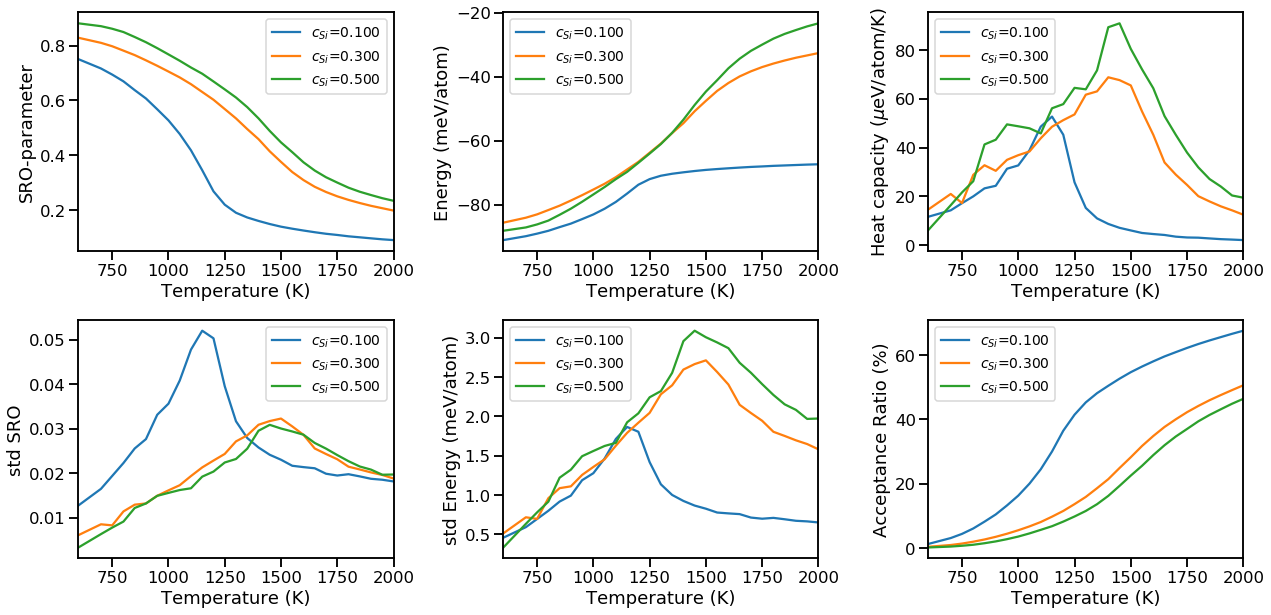

In [3]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

for c_Si in sorted(df_all.c_Si.unique()):
    df = df_all[df_all.c_Si == c_Si]
    df = df.sort_values(by='temperature')
    label = '$c_{Si}$' + '={:.3f}'.format(c_Si)
    ax1.plot(df.temperature, df.sro, label=label)
    ax2.plot(df.temperature, 1e3*df.energy, label=label)
    ax3.plot(df.temperature, 1e6*df.heat_capacity, label=label)
    ax4.plot(df.temperature, df.sro_std, label=label)
    ax5.plot(df.temperature, 1e3*df.energy_std, label=label)
    ax6.plot(df.temperature, 100 * df.acceptance_ratio, label=label)

ax1.set_ylabel('SRO-parameter')
ax2.set_ylabel('Energy (meV/atom)')
ax3.set_ylabel('Heat capacity ($\mu$eV/atom/K)')
ax4.set_ylabel('std SRO')
ax5.set_ylabel('std Energy (meV/atom)')
ax6.set_ylabel('Acceptance Ratio (%)')


for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlim(df_all.temperature.min(), df_all.temperature.max())
    ax.legend(fontsize=14)
    ax.set_xlabel('Temperature (K)')

fig.tight_layout()

From these results we see clear indication of phase-transitions.

To confirm this, try to view the trajectory of a MC simulation above and below the critical temperatures indicate as peaks in standard deviations or heat capacity.

Sampling in canonical ensemble often leads to finite size effects. 

## Semi-grand Canonical simulations
We'll start with collecting the pre-run canonical ensembles and store the thermodynamic properties in a pandas dataframe.


In [4]:
import glob
from mchammer import DataContainer


# parameters
size = 12
eq_steps = 5000


# collect data
fnames = glob.glob('reference_data/sgc_runs/dc_size{}_*.dc'.format(size))

records = []
for fname in fnames:

    # ensemble parameters
    dc = DataContainer.read(fname)
    n_atoms = dc.ensemble_parameters['n_atoms']
    mu_Si = dc.ensemble_parameters['mu_Si']
    T = dc.ensemble_parameters['temperature']

    # thermodynamic data
    energies = dc.get('potential', start=eq_steps)
    conc = dc.get('Si_count', start=eq_steps) / n_atoms
    acceptance_ratio = dc.get('acceptance_ratio', start=eq_steps)

    heat_capacity = np.var(energies) / (kB*T**2) / n_atoms
    energies /= n_atoms

    row = dict(temperature=T, mu_Si=mu_Si, c_Si=conc.mean(), c_Si_std=conc.std(),
               energy=energies.mean(), energy_std=energies.std())
    records.append(row)

df_all = pd.DataFrame(records)
print(df_all)

     temperature    mu_Si  ...    energy  energy_std
0         1200.0  0.03000  ... -0.080305    0.002783
1         1800.0 -0.00900  ... -0.044681    0.003704
2         1200.0 -0.00100  ... -0.088689    0.001734
3         1500.0  0.02375  ... -0.077744    0.002412
4         1200.0 -0.01100  ... -0.090040    0.001617
..           ...      ...  ...       ...         ...
158       1500.0  0.02125  ... -0.076990    0.002510
159       1200.0  0.00900  ... -0.086825    0.002064
160       1200.0  0.05800  ... -0.094448    0.001221
161       1500.0 -0.01875  ... -0.076253    0.002534
162       1800.0  0.01700  ... -0.051705    0.003595

[163 rows x 6 columns]


Next we'll plot the chemical potential and the obtained concentration.

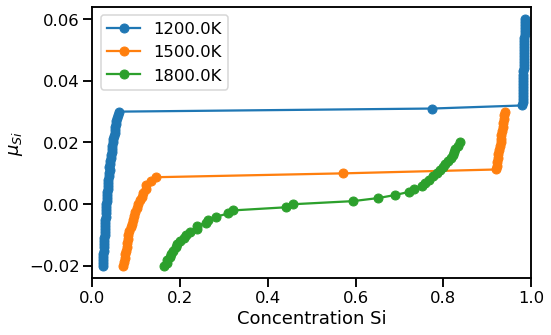

In [5]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)

for T in sorted(df_all.temperature.unique()):
    df = df_all[df_all.temperature == T]
    df = df.sort_values(by='c_Si')
    label = '{}K'.format(T)
    ax1.plot(df.c_Si, df.mu_Si, '-o', label=label)

ax1.set_xlabel('Concentration Si')
ax1.set_ylabel('$\mu_{Si}$')
ax1.set_xlim(df_all.c_Si.min(), df_all.c_Si.max())
ax1.legend()
ax1.set_xlim([0, 1])

fig.tight_layout()

From these simulations we see that there is a miscibility gap for low temperatures which starts to close at higher temperatures.

Compare these points with the ones obtained from the canonical sampling. Do they match?

Note: These simulations have hysteresis with respect to starting from low or high $\mu_{Si}$ which also explains why they are not perfectly symmetric around c=0.5. This makes this type of method slightly unreliable with respect to constructing phase diagrams. A better approach would be to use the Variance Constrained Ensemble.